In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('model.csv')

In [3]:
df.head()

,Unnamed: 0,sim_content,sin_comment,word_count,duplicate_word_ratio,no_of_sentences,length_of_comment,num_of_punctuations,is_period_sequence,stop_word_ratio,post_coment_gap,black_word_count,is_link,is_youtube_link,is_number,is_mail,comment_duplication,classifier_val
0,0,0.372249,0.280355,3.057751,0.083333,3,6.612096,4.0,0,0.000000,8.750086,1.0,1,0,0,0,0.000000,1
1,1,0.354255,0.341604,2.410947,0.000000,1,4.897796,1.0,0,0.000000,15.380144,2.0,0,0,0,0,0.715092,0
2,2,0.487752,0.314966,1.578192,0.000000,1,3.791178,0.0,0,0.000000,14.181022,0.0,0,0,0,0,0.000000,0
3,3,0.468095,0.368193,2.328976,0.000000,1,5.041488,0.0,0,0.090909,13.636652,2.0,0,0,0,0,0.000000,0
4,4,0.366191,0.258061,2.238987,0.000000,1,5.174158,4.0,0,0.000000,13.529500,0.0,1,1,0,0,0.000000,0


In [4]:
df.rename(columns={'Unnamed: 0':'id'},inplace=True)
df.columns

Index(['id', 'sim_content', 'sin_comment', 'word_count',
       'duplicate_word_ratio', 'no_of_sentences', 'length_of_comment',
       'num_of_punctuations', 'is_period_sequence', 'stop_word_ratio',
       'post_coment_gap', 'black_word_count', 'is_link', 'is_youtube_link',
       'is_number', 'is_mail', 'comment_duplication', 'classifier_val'],
      dtype='object')

### Standardization

In [8]:
dfc = df.copy()

In [9]:
y = dfc['classifier_val']
X = dfc.drop(['classifier_val','id'],axis=1)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

### Handle imbalance dataset

In [12]:
dfc['classifier_val'].value_counts()

0    2540
1     585
Name: classifier_val, dtype: int64

In [13]:
from imblearn.combine import SMOTETomek
from collections import Counter

os=SMOTETomek(1)
X_train_os,y_train_os=os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_os)))

X_train = X_train_os
y_train = y_train_os

C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


The number of classes before fit Counter({0: 1778, 1: 409})
The number of classes after fit Counter({1: 1760, 0: 1760})


### Hyperparameter Tuninng

In [14]:
from sklearn import svm

In [16]:
sv =svm.SVC()

In [17]:
sv.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [37]:
grid = {
    'kernel':['rbf'],
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    #'shrinking':[True,False],
    #'probability':[True,False],
   # 'decision_function_shape':['ovo', 'ovr'],
    #'class_weight':[None,'balanced','dict']
    
    
}

In [38]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True) 

In [39]:
from sklearn.model_selection import RandomizedSearchCV
sv_random = RandomizedSearchCV(estimator=sv, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [40]:
sv_random.fit(X_train,y_train)

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 25 is smaller than n_iter=100. Running 25 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   57.5s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=SVC(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   return_train_score=True, scoring='accuracy', verbose=2)

### Evaluvate

In [43]:
best_model = sv_random.best_estimator_

In [44]:
sv_random.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 10}

In [46]:
sv_random.best_score_

0.959090909090909

In [51]:
y_pred = best_model.predict(X_test)

In [53]:
err = (y_pred - y_test)

<AxesSubplot:>

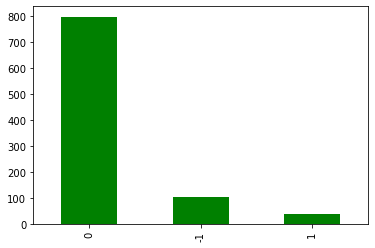

In [56]:
err.value_counts().plot(kind='bar',color='green')

In [48]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.14925373134328357
MSE: 0.14925373134328357
RMSE: 0.3863337046431279


In [49]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[724  38]
 [102  74]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       762
           1       0.66      0.42      0.51       176

    accuracy                           0.85       938
   macro avg       0.77      0.69      0.71       938
weighted avg       0.84      0.85      0.84       938



In [50]:
#import pickle
# open a file, where you ant to store the data
#file = open('random_forest_regression_model_v2.pkl', 'wb')
# dump information to that file
#pickle.dump(rf_random, file)